In [ ]:
import itertools
from pathlib import Path


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from matplotlib.cm import get_cmap

import torch

# set resolution of plt figures to 120
plt.rcParams['figure.dpi'] = 150
# Helvetica doesn't support up arrow unicode
#plt.rcParams['font.family'] = 'Helvetica'

from netam.models import DEFAULT_NEUTRAL_MODEL
from dnsmex.dasm_zoo import validation_burrito_of_pcp_df
from dnsmex.dasm_oe import oe_csp_df_of_burrito
from netam.framework import load_crepe
from dnsmex.local import localify
from dnsmex.dasm_viz import codon_prediction_df_from_sequence
from dnsmex.dxsm_data import pcp_df_of_nickname
import netam
from netam.oe_plot import get_sub_acc_from_csp_df, get_site_subs_acc_df

device = "cpu"
# device = pick_device()
# if device.type == 'mps':
#     print("Actually, using CPU")
#     device = "cpu"

figures_dir = localify("FIGURES_DIR")

2025-01-23 13:26:40.410880: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
igh_naive = "EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLEYMGYISYSGSTYYNPSLKSRISITRDTSKNQYYLQLNSVTTEDTATYYCARDFDVWGAGTTVTVSS"
igh_naive_nt = 'GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTCAGACTCTGTCCCTCACCTGTTCTGTCACTGGCGACTCCATCACCAGTGGTTACTGGAACTGGATCCGGAAATTCCCAGGGAATAAACTTGAGTACATGGGGTACATAAGCTACAGTGGTAGCACTTACTACAATCCATCTCTCAAAAGTCGAATCTCCATCACTCGAGACACATCCAAGAACCAGTACTACCTGCAGTTGAATTCTGTGACTACTGAGGACACAGCCACATATTACTGTGCAAGGGACTTCGATGTCTGGGGCGCAGGGACCACGGTCACCGTCTCCTCA'
# Using mean value from v1rodriguez for computing neutral rates
BRANCH_LENGTH = 0.026

neutral_crepe = netam.pretrained.load(DEFAULT_NEUTRAL_MODEL)

prefix = localify("DASM_GRID_DIR")
nickname = "dasm_1m-v1jaffe+v1tang-joint"
crepe_prefixes = [str(crepe_path)[:-4] for crepe_path in Path(prefix).glob(nickname + "-*.pth")]
crepes = [(crepe_path.name[:-4], load_crepe(str(crepe_path)[:-4])) for crepe_path in Path(prefix).glob(nickname + "-*.pth")]
dataset_name = "v1rodriguez"
model_dasm_crepe_prefix = localify(f"DASM_TRAINED_MODELS_DIR/{nickname}")
test_output_prefix = localify(f"DASM_TEST_OUTPUT_DIR/{nickname}-ON-{dataset_name}")

Using cached models: /home/wdumm/dnsm-netam-proj/netam/netam/_pretrained/thrifty-0.2.0.zip


Index(['dasm_1m'], dtype='object')


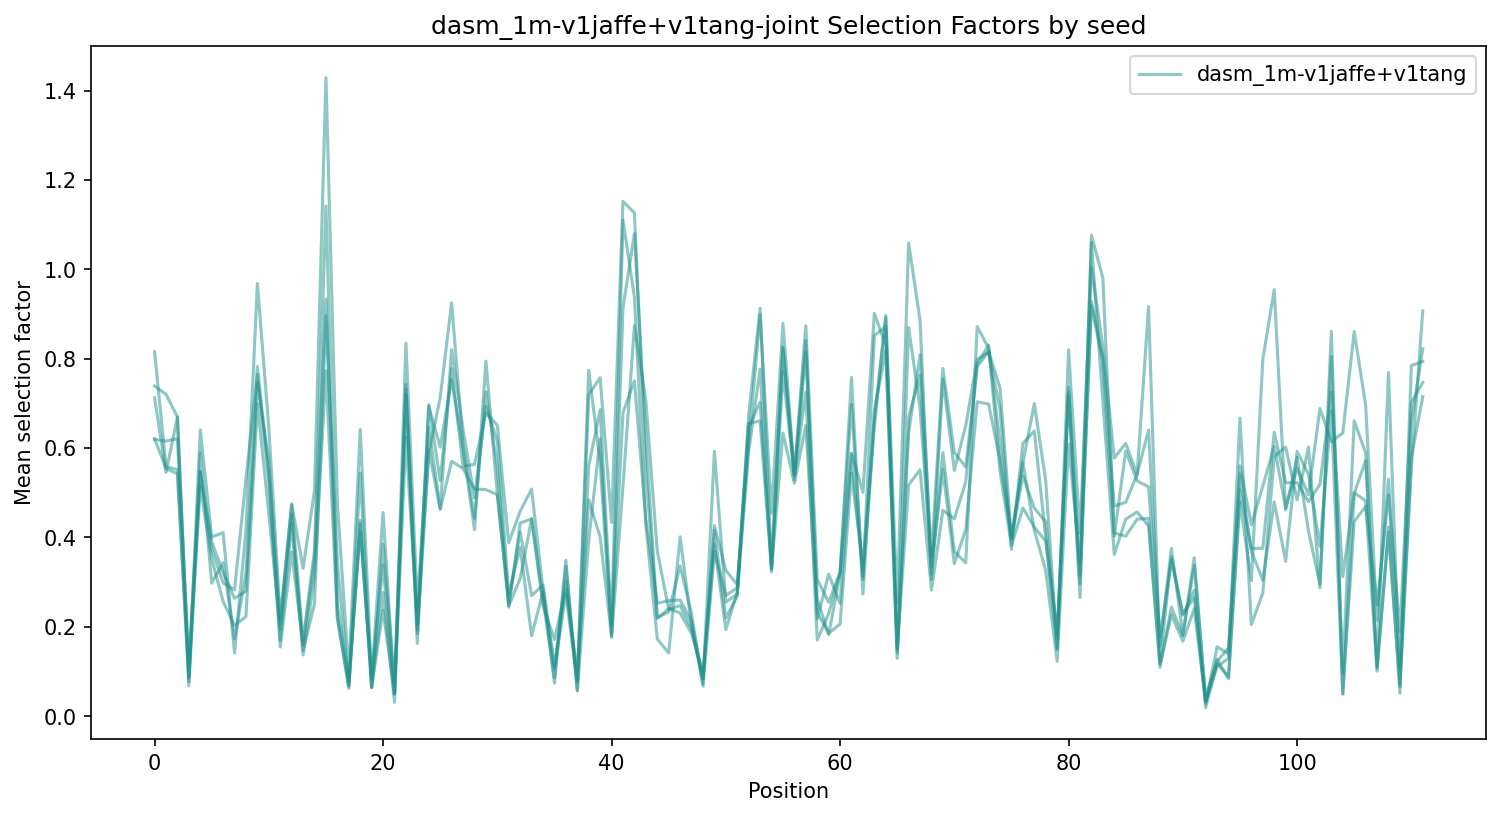

In [3]:


def make_selection_factors_df(seq):
    def selection_factors_of_crepe(crepe):
        res =  crepe.model.selection_factors_of_aa_str(seq)
        # get max value in each column
        # return torch.max(res, dim=1).values
        return torch.mean(res, dim=1)
    
    df = pd.DataFrame({
        model_nickname: selection_factors_of_crepe(crepe)
        for model_nickname, crepe in crepes
    })

    transformed_data = []
    for column in df.columns:
        parts = column.split('-')
        model, dataset, seed = parts[0], parts[1], parts[-1]
        for idx, value in enumerate(df[column]):
            transformed_data.append([idx, value, model, dataset, seed])
    
    return pd.DataFrame(transformed_data, columns=['Position', 'Selection factor', 'Model', 'Dataset', 'Seed'])

def unique_preserving_order(series):
    return pd.Categorical(series, categories=series.unique(), ordered=True).categories

df = make_selection_factors_df(igh_naive)
df
def plot_selection_factors(seq):
    df = make_selection_factors_df(seq)
    fig, ax = plt.subplots(figsize=(12, 6))

    # Define colors and line styles
    unique_models = unique_preserving_order(df['Model'])
    print(unique_models)
    unique_datasets = unique_preserving_order(df['Dataset'])
    unique_seeds = unique_preserving_order(df['Seed'])
    palette = sns.color_palette("viridis", len(unique_models))
    line_styles = ['-', '--', '-.', ':']
    
    # Create a color and linestyle mapping
    color_mapping = {model: color for model, color in zip(unique_models, palette)}
    linestyle_mapping = {dataset: linestyle for dataset, linestyle in zip(unique_datasets, line_styles)}

    grouped = df.groupby(['Model', 'Dataset', 'Seed'])
    legend_added = set()
    # Plot each line
    for (model, dataset, seed) in itertools.product(unique_models, unique_datasets, unique_seeds):
        group = grouped.get_group((model, dataset, seed))
        label = f"{model}-{dataset}" if (model, dataset) not in legend_added else None
        legend_added.add((model, dataset))
        ax.plot(group['Position'], group['Selection factor'], 
                label=label, 
                color=color_mapping[model], 
                alpha=0.5,
                linestyle=linestyle_mapping[dataset])
    
    ax.legend()
    ax.set_xlabel("Position")
    ax.set_ylabel("Mean selection factor")
    plt.title(f'{nickname} Selection Factors by seed')
    return fig

_ = plot_selection_factors(igh_naive)

/tmp/ipykernel_30800/2663248123.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('Dark2')


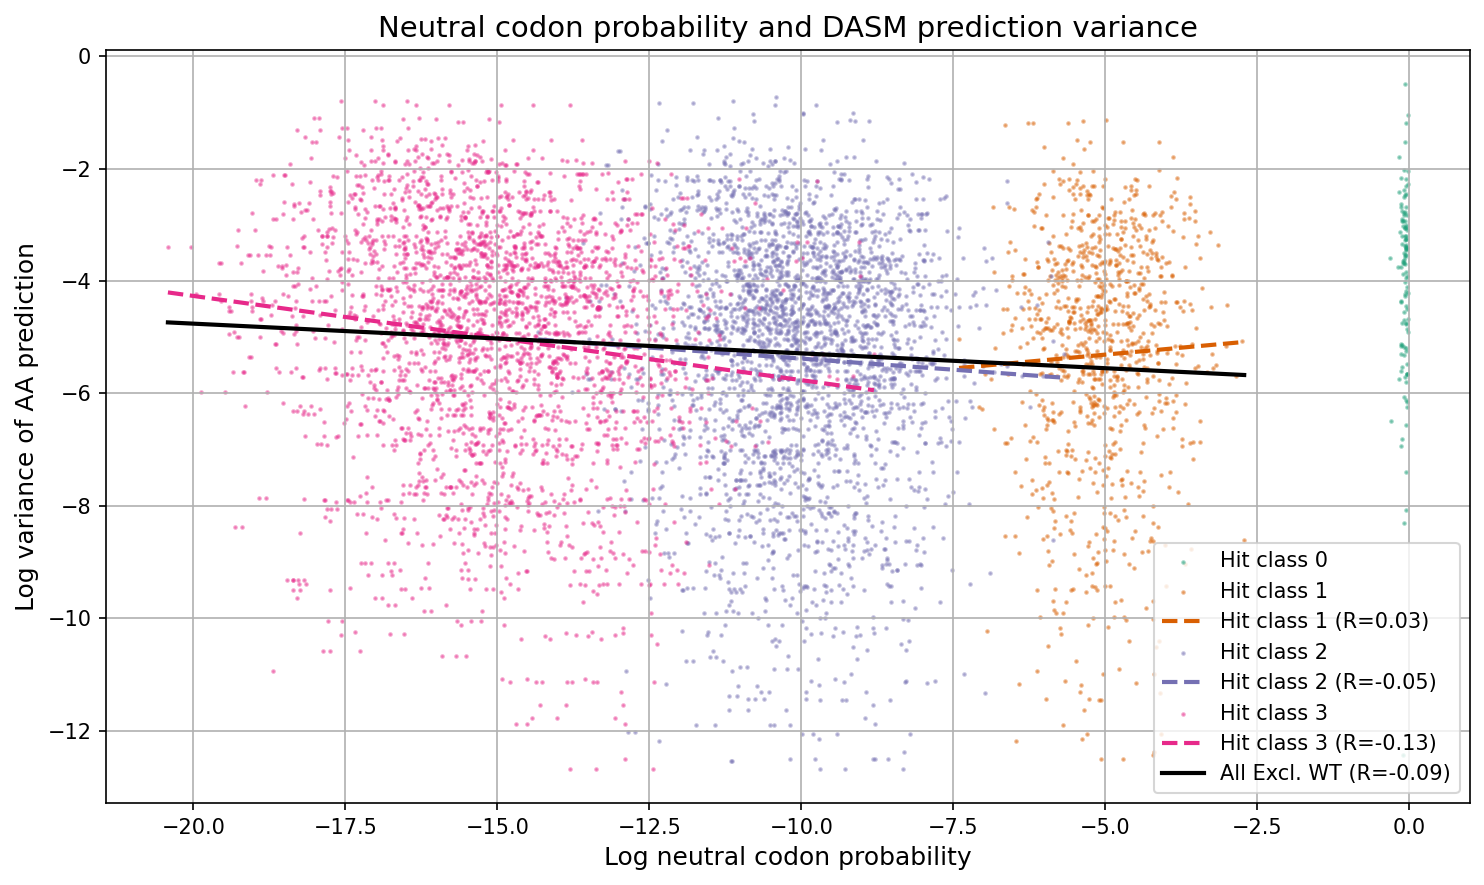

In [4]:
plot_df = codon_prediction_df_from_sequence(igh_naive_nt, neutral_crepe, crepes, BRANCH_LENGTH)
# Log-transform the required columns
plot_df['log_neutral_prob'] = np.log(plot_df['neutral_prob'])
plot_df['log_aa_site_prediction_variance'] = np.log(plot_df['aa_site_prediction_variance'])

# Define the Dark2 color scheme
cmap = get_cmap('Dark2')
unique_hit_classes = plot_df['hit_class'].unique()
color_mapping = {hit_class: cmap(i / len(unique_hit_classes)) for i, hit_class in enumerate(unique_hit_classes)}
color_mapping = ['#1b9e77','#d95f02','#7570b3','#e7298a']

# Function to add regression line
def add_regression_line(ax, x, y, label, color, linestyle='-', linewidth=2):
    x, y = list(x), list(y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    x_fit = np.linspace(min(x), max(x), 10)
    y_fit = slope * x_fit + intercept
    ax.plot(x_fit, y_fit, color=color, linestyle=linestyle, linewidth=linewidth, 
            label=f"{label} (R={r_value:.2f})")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot and regression lines
for hit_class, color in enumerate(color_mapping):
    subset = plot_df[plot_df['hit_class'] == hit_class]
    ax.scatter(
        subset['log_neutral_prob'], 
        subset['log_aa_site_prediction_variance'], 
        label=f"Hit class {hit_class}", 
        color=color, 
        s=1.5,
        alpha=0.4
    )
    if hit_class in [1, 2, 3]:
        add_regression_line(
            ax, 
            subset['log_neutral_prob'], 
            subset['log_aa_site_prediction_variance'], 
            label=f"Hit class {hit_class}", 
            color=color, 
            linestyle='--'
        )

# Exclude hit class 0 for overall regression
non_zero_classes = plot_df[plot_df['hit_class'] != 0]
add_regression_line(
    ax, 
    non_zero_classes['log_neutral_prob'], 
    non_zero_classes['log_aa_site_prediction_variance'], 
    label="All Excl. WT", 
    color='black', 
    linestyle='-', 
    linewidth=2
)

# Add labels, legend, and grid
ax.set_xlabel("Log neutral codon probability", fontsize=12)
ax.set_ylabel("Log variance of AA prediction", fontsize=12)
ax.set_title("Neutral codon probability and DASM prediction variance", fontsize=14)
ax.legend( loc='lower right')
ax.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


## CSP accuracy vs prediction variance

In [5]:
# validation_pcp_df = pcp_df_of_nickname("tst")
validation_pcp_df = pcp_df_of_nickname(dataset_name)
val_burritos = [validation_burrito_of_pcp_df(crepe_prefix, validation_pcp_df, "cpu") for crepe_prefix in crepe_prefixes]

Loading /home/wdumm/data/v1/rodriguez-airr-seq-race-prod-InclMutInv_pcp_2024-11-12_MASKED_NI_noN_no-naive.csv.gz
Filtering out problematic pairs of sample_id and clonal families [('sample-igg-SC-18', 440)]
Filtering PCPs whose ambiguities make them unusable for inference
Using cached models: /home/wdumm/dnsm-netam-proj/netam/netam/_pretrained/thrifty-0.2.0.zip
Using ThriftyHumV0.2-59 for neutral model on device None


Evaluating model: 100%|██████████| 2168/2168 [00:08<00:00, 269.44it/s]


In [6]:
oe_csp_dfs = [oe_csp_df_of_burrito(burr, validation_pcp_df) for burr in val_burritos]

Calculating OE CSP data: 100%|██████████| 22/22 [02:53<00:00,  7.87s/it]


In [7]:
suffix_base = "seed-"
# Identify common columns to merge on (excluding probability columns)
non_prob_columns = list(
    oe_csp_dfs[0].columns.difference([col for col in oe_csp_dfs[0].columns if "prob" in col])
)

# Perform nested merging
merged_df = oe_csp_dfs[0].copy()
for i, df in enumerate(oe_csp_dfs[1:], start=1):
    merged_df = pd.merge(
        merged_df,
        df,
        on=non_prob_columns,
        suffixes=("", f"{suffix_base}{i}")
    )

# Example usage:
# Assuming oe_csp_dfs is a list of DataFrames and pcp_df is another DataFrame
# merged_df = nested_merge(oe_csp_dfs, pcp_df)

In [8]:
prob_columns = ["prob", "probseed-1", "probseed-2", "probseed-3", "probseed-4"]
log_transformed = np.log(merged_df[prob_columns])
merged_df["log_prob_mean"] = log_transformed.mean(axis=1)
merged_df["log_prob_var"] = log_transformed.var(axis=1)
merged_df["coeff_var_log_p"] = log_transformed.std(axis=1) / log_transformed.mean(axis=1)

/home/wdumm/dnsm-netam-proj/.pixi/envs/cuda/lib/python3.9/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/wdumm/dnsm-netam-proj/.pixi/envs/cuda/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/wdumm/dnsm-netam-proj/.pixi/envs/cuda/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [9]:
# Step 1: Select AA with the largest mean probability for each site of each pcp_index
selected_rows = merged_df.loc[merged_df.groupby(['pcp_index', 'site'])['log_prob_mean'].idxmax()]

# Step 2: Divide into bins based on coefficient of variation and calculate substitution accuracy
median_cv = selected_rows['coeff_var_log_p'].median()
high_confidence = selected_rows[selected_rows['coeff_var_log_p'] <= median_cv]
low_confidence = selected_rows[selected_rows['coeff_var_log_p'] > median_cv]

high_conf_accuracy = high_confidence['is_target'].mean()
low_conf_accuracy = low_confidence['is_target'].mean()

# Displaying results
print("Among pcp-sites with lower-than-median coefficient of variation of log-p for observed target, csp accuracy is", high_conf_accuracy)
print("Among pcp-sites with higher-than-median coefficient of variation of log-p for observed target, csp accuracy is", low_conf_accuracy)

Among pcp-sites with lower-than-median coefficient of variation of log-p for observed target, csp accuracy is 0.43586665585205614
Among pcp-sites with higher-than-median coefficient of variation of log-p for observed target, csp accuracy is 0.353351502173772


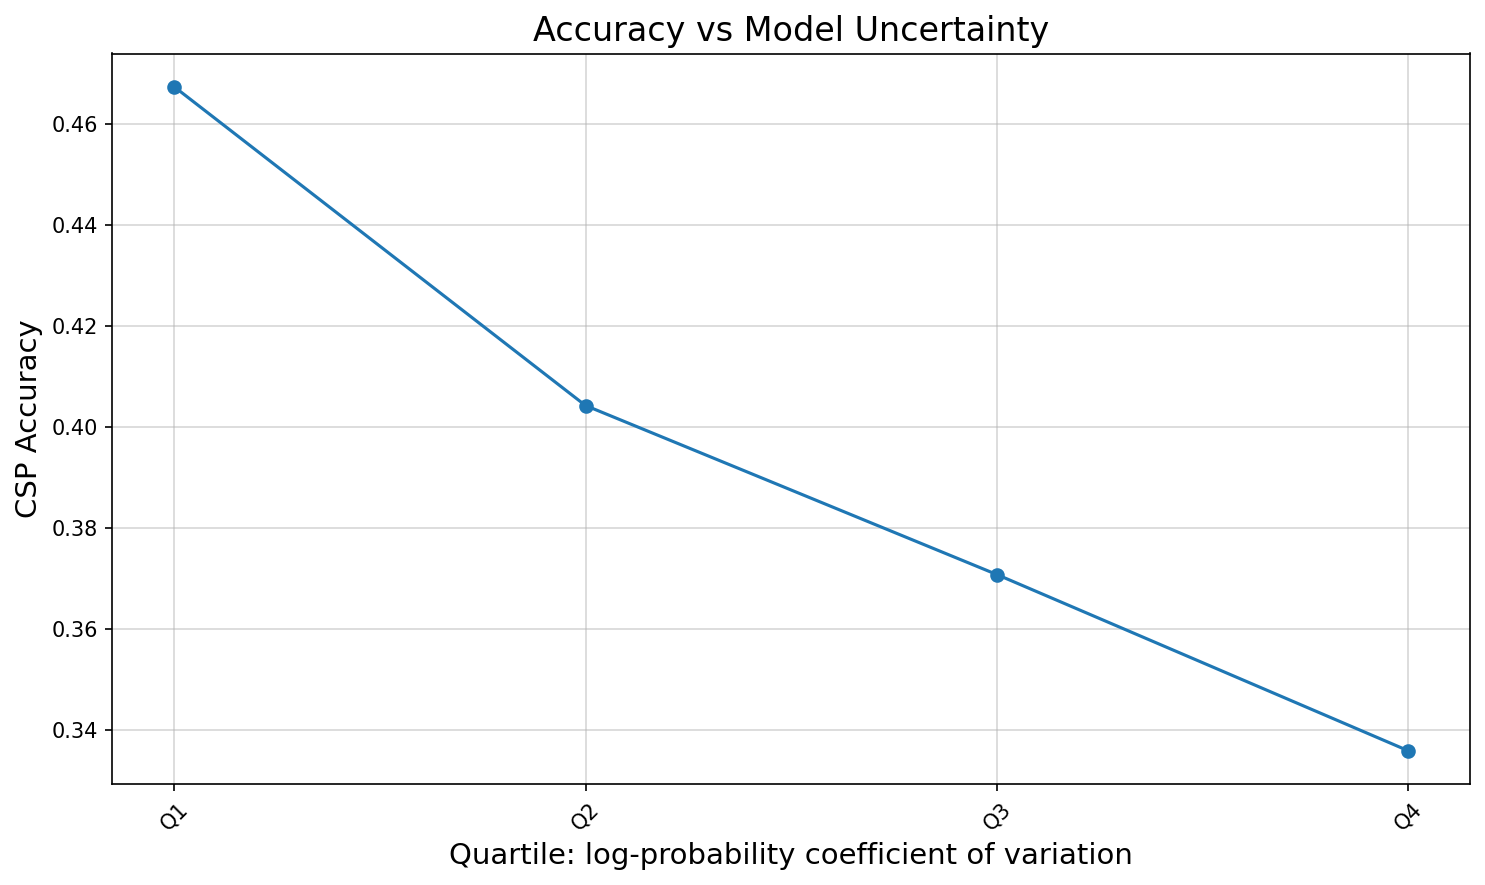

In [10]:
selected_rows['confidence_quartile'] = pd.qcut(selected_rows['coeff_var_log_p'], 4, labels=False)

# Calculate accuracy for each quartile
quartile_accuracy = selected_rows.groupby('confidence_quartile')['is_target'].mean()

plt.figure(figsize=(10, 6))
plt.plot(quartile_accuracy.index, quartile_accuracy.values, marker='o')
plt.title('Accuracy vs Model Uncertainty', fontsize=16)
plt.xlabel('Quartile: log-probability coefficient of variation', fontsize=14)
plt.ylabel('CSP Accuracy', fontsize=14)
plt.xticks(quartile_accuracy.index, labels=[f'Q{d+1}' for d in quartile_accuracy.index], rotation=45)
plt.grid(True, alpha=0.5)
plt.tight_layout()

# # Or a bar chart:
# plt.bar(quartile_accuracy.index, quartile_accuracy.values, alpha=0.8)
# plt.title('Accuracy vs Model Uncertainty', fontsize=16)
# plt.ylabel('CSP Accuracy', fontsize=14)
# plt.ylabel('CSP Accuracy', fontsize=14)
# plt.xticks(quartile_accuracy.index, labels=[f'Q{d+1}' for d in quartile_accuracy.index], rotation=45)
# plt.grid(axis='y', alpha=0.5)
# plt.tight_layout()